## Problem 3 Part C

In [1]:
import numpy as np
from scipy.stats import norm

In [2]:
num_trials = int(1e4)
ps = [0.1, 0.3, 0.5]
ns = [10, 40, 100]

sims={}
for p in ps: 
    sims[str(p)] = {}
    for n in ns: 
        sims[str(p)][n] = np.random.binomial(n, p, (num_trials))
        
sims["0.3"][40]

array([17, 10, 16, ..., 15,  8, 12])

In [3]:
def get_part_a_interval(phats, p, n): 
    z = norm.ppf(1-0.025)
    
    delta = np.sqrt(phats*(1-phats)/n) * z
    
    return phats - delta, phats + delta

print("part A interval lower and upper: ", get_part_a_interval(np.array([0.11, 0.12]), 0.115, 1000))

def get_part_b_interval(phats, p, n): 
    z = norm.ppf(1-0.025)
    
    center = phats + z**2 / (2*n)
    
    delta = z * np.sqrt(phats*(1-phats)/n + z**2/(4*n**2))
    
    normalizer = 1 + z**2/n 
    
    return (center-delta)/normalizer, (center+delta)/normalizer

print("part B interval lowers and uppers", get_part_b_interval(np.array([0.11, 0.12]), 0.115, 1000))

part A interval lower and upper:  (array([0.09060725, 0.09985905]), array([0.12939275, 0.14014095]))
part B interval lowers and uppers (array([0.09207937, 0.10129926]), array([0.1309055 , 0.14160908]))


In [4]:
def report_coverage(sims, p, n, get_interval): 
    phats = sims / n
    lower, upper = get_interval(phats, p, n)
        
    covered = np.logical_and(p > lower, p < upper).astype(int)
    
    return np.mean(covered)

In [5]:
for p in ps: 
    for n in ns: 
        a_coverage = report_coverage(sims[str(p)][n], p, n, get_part_a_interval)
        print(f"n={n}, p={p}, part a coverage: {a_coverage}",)
        b_coverage = report_coverage(sims[str(p)][n], p, n, get_part_b_interval)
        print(f"n={n}, p={p}, part b coverage: {b_coverage}",)

n=10, p=0.1, part a coverage: 0.6427
n=10, p=0.1, part b coverage: 0.9304
n=40, p=0.1, part a coverage: 0.9129
n=40, p=0.1, part b coverage: 0.9381
n=100, p=0.1, part a coverage: 0.9314
n=100, p=0.1, part b coverage: 0.9348
n=10, p=0.3, part a coverage: 0.8462
n=10, p=0.3, part b coverage: 0.9266
n=40, p=0.3, part a coverage: 0.93
n=40, p=0.3, part b coverage: 0.9461
n=100, p=0.3, part a coverage: 0.9474
n=100, p=0.3, part b coverage: 0.9356
n=10, p=0.5, part a coverage: 0.8931
n=10, p=0.5, part b coverage: 0.9782
n=40, p=0.5, part a coverage: 0.9232
n=40, p=0.5, part b coverage: 0.9647
n=100, p=0.5, part a coverage: 0.9462
n=100, p=0.5, part b coverage: 0.9462


The test from part (B) yields much better coverage for small values of n, especially when p is small 

# Problem 4

In [6]:
from scipy.special import gamma, digamma, polygamma
from matplotlib import pyplot as plt
from tqdm import tqdm

## Part A

Below we define the function $f(\alpha)$ from lecture 13. This function has the property that $f(\alpha)=0$ iff $\alpha$ is the MLE. We also define its derivative

$$f'(\alpha) = \frac{1}{\alpha} - \frac{\Gamma''(\alpha)\Gamma(\alpha)-\Gamma'(\alpha)^2}{\Gamma(\alpha)^2}$$

Note that `polygamma(1, z)` is the trigamma function.

In [7]:
def f(alpha, x): 
    term_1 = np.log(alpha)
    term_2 = -digamma(alpha)
    term_3 = -np.log(np.mean(x))
    term_4 = np.mean(np.log(x))
    return term_1 + term_2 + term_3 + term_4
    
def f_prime(alpha): 
    return 1/alpha - polygamma(1, alpha)

In [8]:
def update(alpha, x): 
    return max(alpha - f(alpha, x)/f_prime(alpha), 1e-10)

## Part B

100%|████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 259.54it/s]


alpha mean: 1.0053403088002046
alpha variance: 0.003136007404175372


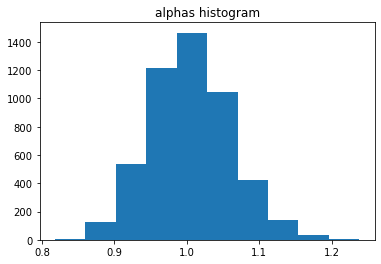

beta mean: 2.014524881226936
beta variance: 0.020349896243377113


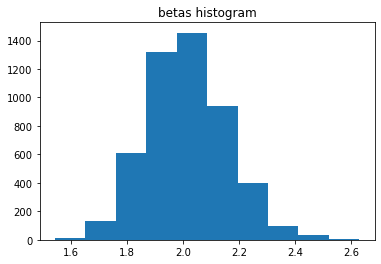

alpha and beta covariance: 0.006217366169198483


In [9]:
# numpy's gamma distribution takes shape and scale parameters, 
# rather than shape and rate.
alphas = []
betas = []
for _ in tqdm(range(5000)):
    x = np.random.gamma(1, 1/2, (500))
    x_bar = np.mean(x)
    alpha_init = x_bar**2 / np.mean((x-x_bar)**2)
    alpha = alpha_init
    for _ in range(100): 
        alpha = update(alpha, x)
    alphas.append(alpha)
    betas.append(alpha/x_bar)
        

print(f"alpha mean: {np.mean(alphas)}")
print(f"alpha variance: {np.var(alphas)}")
plt.cla()
plt.hist(alphas)
plt.title("alphas histogram")
plt.show()
print(f"beta mean: {np.mean(betas)}")
print(f"beta variance: {np.var(betas)}")
plt.hist(betas)
plt.title("betas histogram")
plt.show()
print(f"alpha and beta covariance: {np.cov(np.stack((alphas, betas)))[0,1]}")

## Part C
The value of $\frac{1}{n}I(1, 2)^{-1}$ is

In [10]:
alpha = 1
beta = 2
constant = 1/500 * 1/(alpha*polygamma(1,alpha)-1) 
mat = np.array([[alpha, beta], [beta, beta**2*polygamma(1, alpha)]])
cov_matrix = constant * mat
print(cov_matrix)

[[0.00310109 0.00620218]
 [0.00620218 0.02040437]]


Our simulations very closely match the approximate distribution of $\mathcal{N}((1, 2), \frac{1}{n}I(1,2)^{-1})$